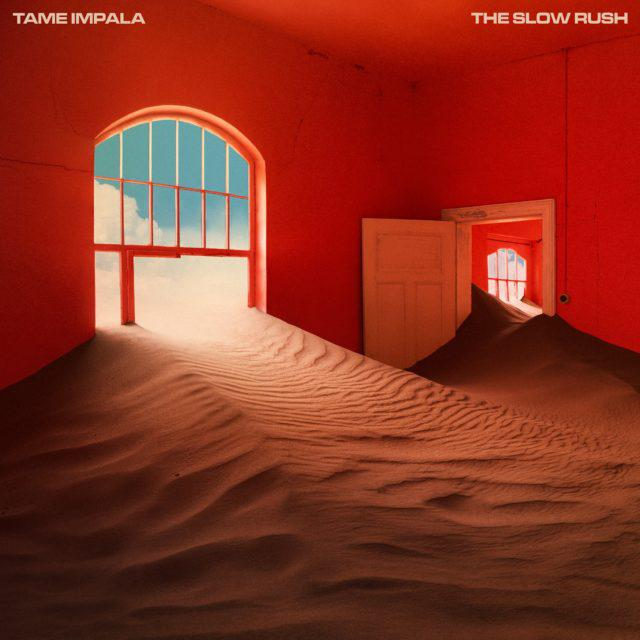

In [1]:
from io import StringIO, BytesIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# ### LOAD DNN MODEL
# model_path = '../caffe/models/bvlc_googlenet/' # substitute your path here
# net_fn   = model_path + 'deploy.prototxt'
# param_fn = model_path + 'bvlc_googlenet.caffemodel'

# model_path = './placesCNN/' # JUST DOWNLOAD THE GOOGLENET ONE IF THIS DOESNT WORK
# net_fn   = model_path + 'places205CNN_deploy.prototxt'
# param_fn = model_path + 'places205CNN_iter_300000.caffemodel'

model_path = './googlenet_places205/'
net_fn   = model_path + 'deploy_places205.protxt'
param_fn = model_path + 'googlelet_places205_train_iter_2400000.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

### PRODUCE DREAMS
def objective_L2(dst):
    dst.diff[:] = dst.data

def make_step(net, step_size=1.5, end='inception_4c/output',
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift

    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image

    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)

## Implementing an ascent thru different octaves/scales
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4,
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in range(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))

    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in range(iter_n):
            make_step(net, end=end, clip=clip, **step_params)

            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print(octave, i, end, vis.shape)
            clear_output(wait=True)

        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

## IMPORT PICTURE
img = np.float32(PIL.Image.open('slowrush.jpeg'))
showarray(img)

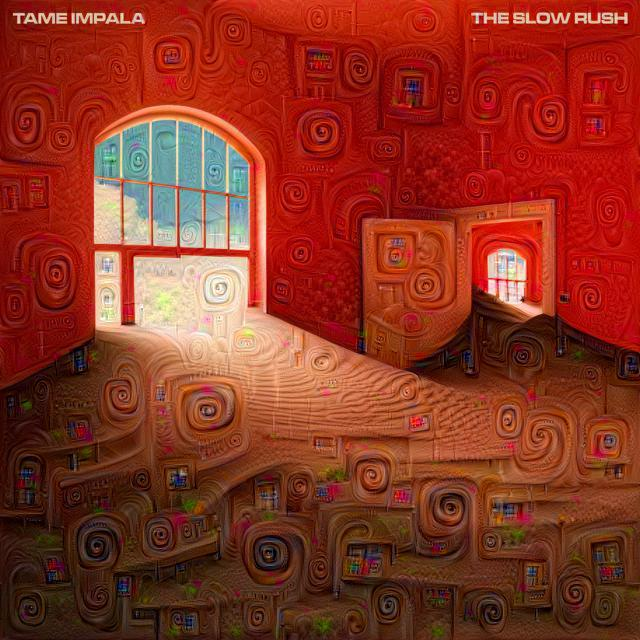

3 9 inception_4a/pool_proj (640, 640, 3)


In [2]:
_=deepdream(net, img, end='inception_4a/pool_proj')
#end=___ to change the level of detail for deepdream to maximize

In [13]:
# See the levels of the model Deep Dream can maximize
net.blobs.keys()

odict_keys(['data', 'conv1/7x7_s2', 'pool1/3x3_s2', 'pool1/norm1', 'conv2/3x3_reduce', 'conv2/3x3', 'conv2/norm2', 'pool2/3x3_s2', 'pool2/3x3_s2_pool2/3x3_s2_0_split_0', 'pool2/3x3_s2_pool2/3x3_s2_0_split_1', 'pool2/3x3_s2_pool2/3x3_s2_0_split_2', 'pool2/3x3_s2_pool2/3x3_s2_0_split_3', 'inception_3a/1x1', 'inception_3a/3x3_reduce', 'inception_3a/3x3', 'inception_3a/5x5_reduce', 'inception_3a/5x5', 'inception_3a/pool', 'inception_3a/pool_proj', 'inception_3a/output', 'inception_3a/output_inception_3a/output_0_split_0', 'inception_3a/output_inception_3a/output_0_split_1', 'inception_3a/output_inception_3a/output_0_split_2', 'inception_3a/output_inception_3a/output_0_split_3', 'inception_3b/1x1', 'inception_3b/3x3_reduce', 'inception_3b/3x3', 'inception_3b/5x5_reduce', 'inception_3b/5x5', 'inception_3b/pool', 'inception_3b/pool_proj', 'inception_3b/output', 'pool3/3x3_s2', 'pool3/3x3_s2_pool3/3x3_s2_0_split_0', 'pool3/3x3_s2_pool3/3x3_s2_0_split_1', 'pool3/3x3_s2_pool3/3x3_s2_0_split_2', 

In [35]:
# !mkdir frames
frame = img
frame_i = 0

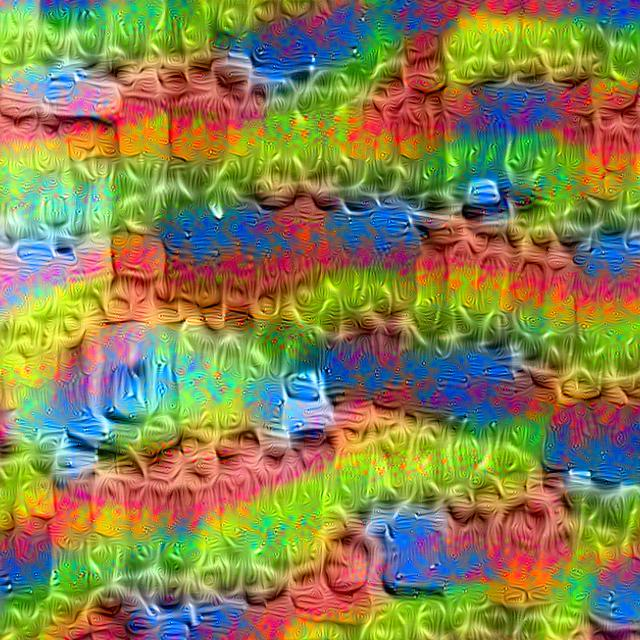

3 9 inception_3a/5x5 (640, 640, 3)


In [7]:
h, w = frame.shape[:2]
s = 0.02 # scale coefficient
for i in range(18):
    frame = deepdream(net, frame, end='inception_3a/5x5')
    PIL.Image.fromarray(np.uint8(frame)).save("frames/%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1

In [32]:
keys = list(net.blobs.keys())[12:]
detailedkeys = keys[75:]

In [30]:
h, w = frame.shape[:2]
s = 0.01 # scale coefficient
for item in keys[::30]:
    for i in range(10):
        frame = deepdream(net, frame, end=item)
        PIL.Image.fromarray(np.uint8(frame)).save("frames/%04d.jpg"%frame_i)
        frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
        frame_i += 1

KeyboardInterrupt: 

In [38]:
h, w = frame.shape[:2]
s = 0.01 # scale coefficient
for item in detailedkeys[::3]:
    for i in range(10):
        frame = deepdream(net, frame, end=item)
        PIL.Image.fromarray(np.uint8(frame)).save("frames/%04d.jpg"%frame_i)
        frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
        frame_i += 1

KeyboardInterrupt: 

In [31]:
len(keys)
keys
detailedkeys

['inception_4e/3x3',
 'inception_4e/5x5_reduce',
 'inception_4e/5x5',
 'inception_4e/pool',
 'inception_4e/pool_proj',
 'inception_4e/output',
 'pool4/3x3_s2',
 'pool4/3x3_s2_pool4/3x3_s2_0_split_0',
 'pool4/3x3_s2_pool4/3x3_s2_0_split_1',
 'pool4/3x3_s2_pool4/3x3_s2_0_split_2',
 'pool4/3x3_s2_pool4/3x3_s2_0_split_3',
 'inception_5a/1x1',
 'inception_5a/3x3_reduce',
 'inception_5a/3x3',
 'inception_5a/5x5_reduce',
 'inception_5a/5x5',
 'inception_5a/pool',
 'inception_5a/pool_proj',
 'inception_5a/output',
 'inception_5a/output_inception_5a/output_0_split_0',
 'inception_5a/output_inception_5a/output_0_split_1',
 'inception_5a/output_inception_5a/output_0_split_2',
 'inception_5a/output_inception_5a/output_0_split_3',
 'inception_5b/1x1',
 'inception_5b/3x3_reduce',
 'inception_5b/3x3',
 'inception_5b/5x5_reduce',
 'inception_5b/5x5',
 'inception_5b/pool',
 'inception_5b/pool_proj',
 'inception_5b/output',
 'pool5/7x7_s1',
 'loss3/classifier',
 'prob']